In [1]:
from google.colab import files
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
trader_df = pd.read_csv("historical_data.csv")
fear_greed_df = pd.read_csv("fear_greed_index.csv")
trader_df.columns = trader_df.columns.str.strip().str.lower()
fear_greed_df.columns = fear_greed_df.columns.str.strip().str.lower()
trader_df['timestamp ist'] = pd.to_datetime(trader_df['timestamp ist'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['timestamp ist'].dt.date
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date']).dt.date
df = pd.merge(trader_df, fear_greed_df, on='date', how='left')
df.rename(columns={'classification': 'sentiment'}, inplace=True)
print("Data merged successfully. Sample:")
print(df[['account', 'coin', 'execution price', 'size tokens', 'side', 'timestamp ist', 'sentiment']].head())



Data merged successfully. Sample:
                                      account  coin  execution price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size tokens side       timestamp ist      sentiment  
0       986.87  BUY 2024-12-02 22:50:00  Extreme Greed  
1        16.00  BUY 2024-12-02 22:50:00  Extreme Greed  
2       144.09  BUY 2024-12-02 22:50:00  Extreme Greed  
3       142.98  BUY 2024-12-02 22:50:00  Extreme Greed  
4         8.73  BUY 2024-12-02 22:50:00  Extreme Greed  


In [3]:
df['profit_margin'] = df.apply(
    lambda row: row['closed pnl'] / (row['execution price'] * row['size tokens']) if row['execution price'] * row['size tokens'] > 0 else 0,
    axis=1
)
df['risk_score'] = df['size usd']
df['is_profitable'] = df['closed pnl'] > 0
def determine_bias(row):
    if row['side'].upper() == 'BUY' and row['sentiment'] == 'Fear':
        return 'Contrarian'
    elif row['side'].upper() == 'SELL' and row['sentiment'] == 'Greed':
        return 'Contrarian'
    else:
        return 'Aligned'

df['holding_bias'] = df.apply(determine_bias, axis=1)
print(df[['side', 'sentiment', 'holding_bias', 'profit_margin', 'risk_score', 'is_profitable']].head())


  side      sentiment holding_bias  profit_margin  risk_score  is_profitable
0  BUY  Extreme Greed      Aligned            0.0     7872.16          False
1  BUY  Extreme Greed      Aligned            0.0      127.68          False
2  BUY  Extreme Greed      Aligned            0.0     1150.63          False
3  BUY  Extreme Greed      Aligned            0.0     1142.04          False
4  BUY  Extreme Greed      Aligned            0.0       69.75          False


In [19]:
df.to_csv(r"C:\Users\91984\Downloads\merged_featured_data.csv", index=False)


In [4]:
trader_profile = df.groupby('account').agg({
    'profit_margin': 'mean',
    'risk_score': 'mean',
    'is_profitable': ['mean', 'count']
})
trader_profile.columns = ['avg_profit_margin', 'avg_risk_score', 'profitability_ratio', 'total_trades']
trader_profile = trader_profile.reset_index()
print(trader_profile.head())


                                      account  avg_profit_margin  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012           0.032565   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd           0.001074   
2  0x271b280974205ca63b716753467d5a371de622ab           0.000122   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4           0.052404   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd           0.023537   

   avg_risk_score  profitability_ratio  total_trades  
0    16159.576734             0.359612          3818  
1     1653.226327             0.442720          7280  
2     8893.000898             0.301917          3809  
3      507.626933             0.438585         13311  
4     3138.894782             0.519914          3239  


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
features = ['avg_profit_margin', 'avg_risk_score', 'profitability_ratio', 'total_trades']
scaler = StandardScaler()
X = scaler.fit_transform(trader_profile[features])
kmeans = KMeans(n_clusters=4, random_state=42)
trader_profile['cluster'] = kmeans.fit_predict(X)
print(trader_profile[['account', 'cluster']].head())


                                      account  cluster
0  0x083384f897ee0f19899168e3b1bec365f52a9012        3
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd        0
2  0x271b280974205ca63b716753467d5a371de622ab        3
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4        1
4  0x2c229d22b100a7beb69122eed721cee9b24011dd        0


In [6]:
cluster_labels = {
    0: 'Smart Sniper',        #
    1: 'Greedy Whale',        #
    2: 'Consistent Grinder',  #
    3: 'Risky Newbie'         #
}

trader_profile['archetype'] = trader_profile['cluster'].map(cluster_labels)
print(trader_profile[['account', 'archetype']].head())

                                      account     archetype
0  0x083384f897ee0f19899168e3b1bec365f52a9012  Risky Newbie
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  Smart Sniper
2  0x271b280974205ca63b716753467d5a371de622ab  Risky Newbie
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  Greedy Whale
4  0x2c229d22b100a7beb69122eed721cee9b24011dd  Smart Sniper


In [7]:
df = df.merge(trader_profile[['account', 'archetype']], on='account', how='left')


In [8]:
archetype_sentiment_stats = df.groupby(['sentiment', 'archetype']).agg({
    'profit_margin': 'mean',
    'is_profitable': 'mean',
    'account': 'count'
}).reset_index()

archetype_sentiment_stats.rename(columns={
    'profit_margin': 'avg_profit_margin',
    'is_profitable': 'success_rate',
    'account': 'total_trades'
}, inplace=True)

print(archetype_sentiment_stats)


        sentiment           archetype  avg_profit_margin  success_rate  \
0    Extreme Fear  Consistent Grinder          -0.078898      0.110266   
1    Extreme Fear        Greedy Whale           0.004192      0.375824   
2    Extreme Fear        Risky Newbie           0.006974      0.348708   
3    Extreme Fear        Smart Sniper           0.006608      0.395588   
4   Extreme Greed  Consistent Grinder          -2.165768      0.459627   
5   Extreme Greed        Greedy Whale           0.060031      0.471196   
6   Extreme Greed        Risky Newbie           0.016423      0.280721   
7   Extreme Greed        Smart Sniper           0.055086      0.684181   
8            Fear  Consistent Grinder           0.008088      0.679688   
9            Fear        Greedy Whale           0.010106      0.413298   
10           Fear        Risky Newbie           0.042946      0.387206   
11           Fear        Smart Sniper           0.006499      0.456441   
12          Greed  Consistent Grinder 

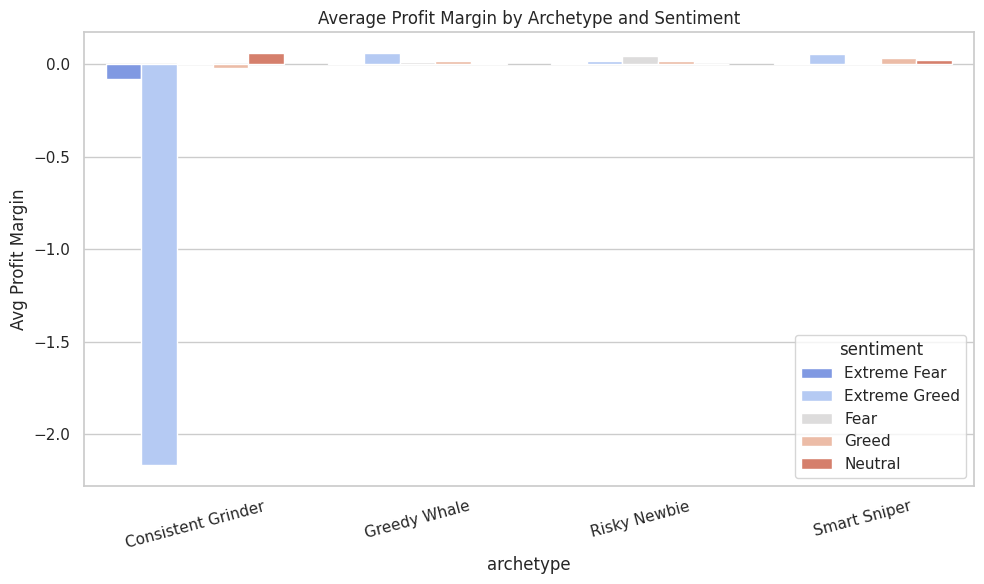

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=archetype_sentiment_stats,
    x='archetype',
    y='avg_profit_margin',
    hue='sentiment',
    palette='coolwarm'
)
plt.title('Average Profit Margin by Archetype and Sentiment')
plt.ylabel('Avg Profit Margin')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


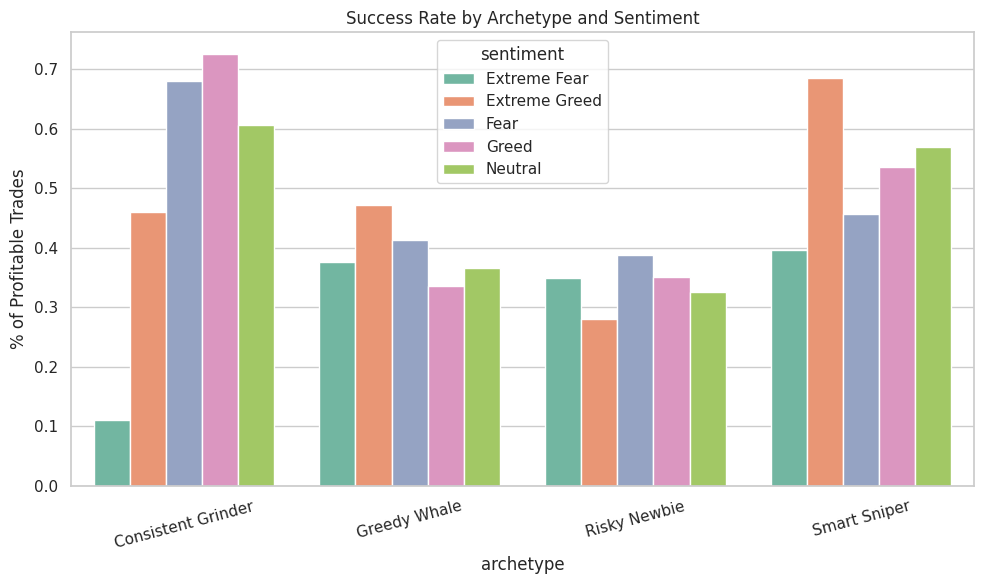

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=archetype_sentiment_stats,
    x='archetype',
    y='success_rate',
    hue='sentiment',
    palette='Set2'
)
plt.title('Success Rate by Archetype and Sentiment')
plt.ylabel('% of Profitable Trades')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


   risk_score  profit_margin                quadrant
0     7872.16            0.0  High Risk / Low Reward
1      127.68            0.0   Low Risk / Low Reward
2     1150.63            0.0  High Risk / Low Reward
3     1142.04            0.0  High Risk / Low Reward
4       69.75            0.0   Low Risk / Low Reward
   risk_score  profit_margin                quadrant
0     7872.16            0.0  High Risk / Low Reward
1      127.68            0.0   Low Risk / Low Reward
2     1150.63            0.0  High Risk / Low Reward
3     1142.04            0.0  High Risk / Low Reward
4       69.75            0.0   Low Risk / Low Reward
sentiment                Extreme Fear  Extreme Greed       Fear      Greed  \
quadrant                                                                     
High Risk / High Reward     22.341121      19.023805  23.275709  19.438204   
High Risk / Low Reward      33.257009      25.472595  30.991154  29.059897   
Low Risk / High Reward      14.719626      27.470494

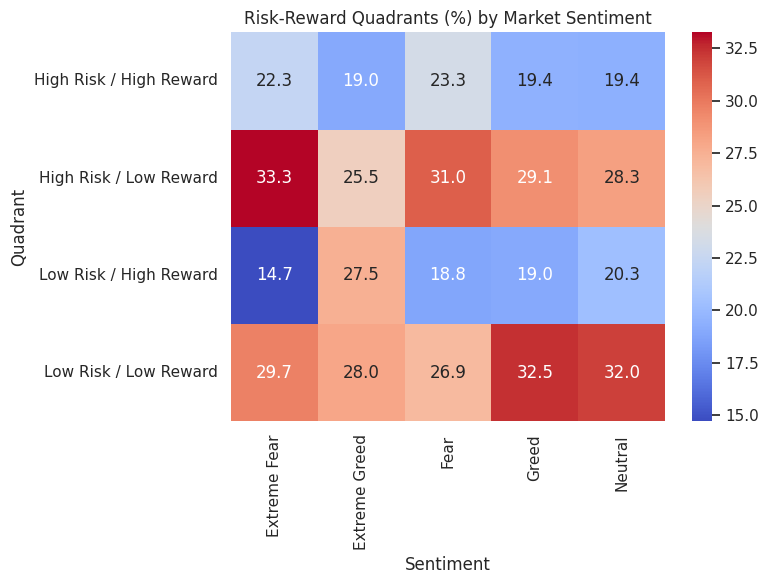

In [11]:
df['reward_level'] = pd.qcut(df['profit_margin'], 2, labels=['Low Reward', 'High Reward'])
df['risk_level'] = pd.qcut(df['risk_score'], 2, labels=['Low Risk', 'High Risk'])
df['quadrant'] = df['risk_level'].astype(str) + ' / ' + df['reward_level'].astype(str)
print(df[['risk_score', 'profit_margin', 'quadrant']].head())
df['reward_level'] = pd.qcut(df['profit_margin'], 2, labels=['Low Reward', 'High Reward'])
df['risk_level'] = pd.qcut(df['risk_score'], 2, labels=['Low Risk', 'High Risk'])
df['quadrant'] = df['risk_level'].astype(str) + ' / ' + df['reward_level'].astype(str)
print(df[['risk_score', 'profit_margin', 'quadrant']].head())
quadrant_summary = pd.crosstab(df['quadrant'], df['sentiment'], normalize='columns') * 100
print(quadrant_summary)
plt.figure(figsize=(8, 6))
sns.heatmap(quadrant_summary, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Risk-Reward Quadrants (%) by Market Sentiment")
plt.ylabel("Quadrant")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()


In [12]:
symbol_stats = df.groupby(['coin', 'sentiment']).agg({
    'profit_margin': 'mean',
    'closed pnl': 'mean',
    'account': 'count'
}).reset_index()

symbol_stats.rename(columns={
    'account': 'num_trades',
    'profit_margin': 'avg_profit_margin',
    'closed pnl': 'avg_pnl'
}, inplace=True)

# Preview
print(symbol_stats.head())


  coin      sentiment  avg_profit_margin    avg_pnl  num_trades
0   @1  Extreme Greed           0.284404  18.358058          27
1   @1           Fear           0.000000   0.000000           1
2   @1          Greed          -0.025690   0.179780           6
3  @10   Extreme Fear          -0.001503  -0.031742           2
4  @10           Fear           0.000000   0.000000           1


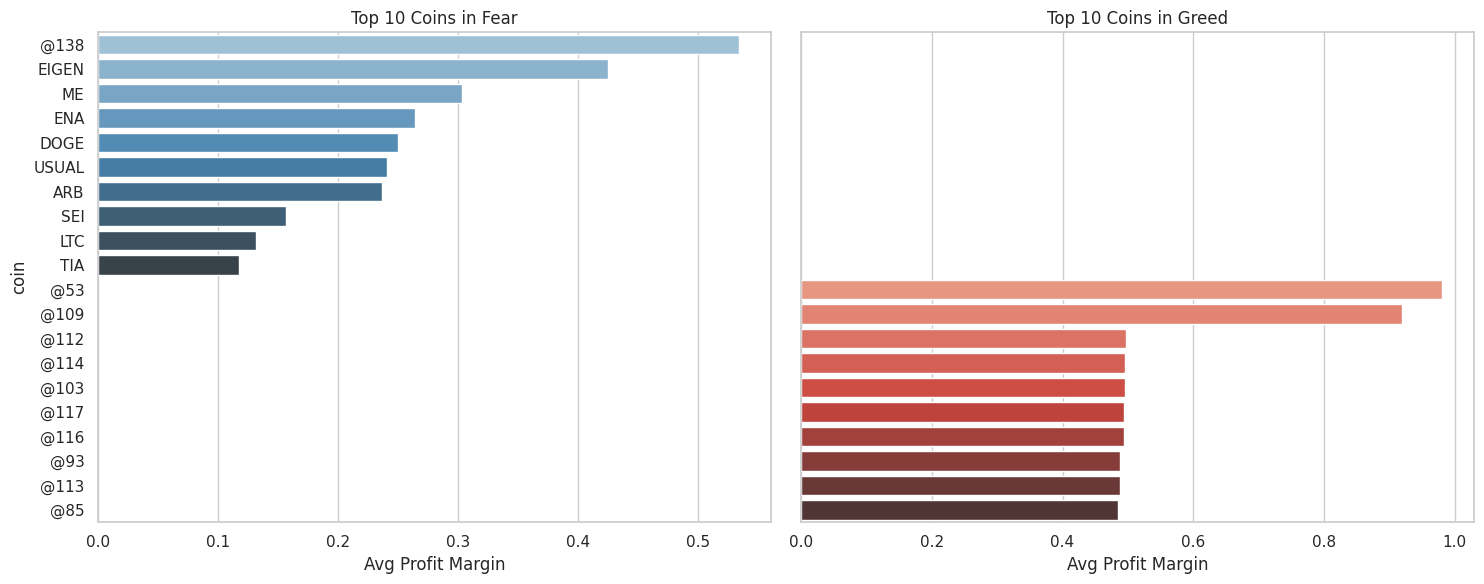

In [13]:
top_fear = symbol_stats[symbol_stats['sentiment'] == 'Fear'].sort_values('avg_profit_margin', ascending=False).head(10)
top_greed = symbol_stats[symbol_stats['sentiment'] == 'Greed'].sort_values('avg_profit_margin', ascending=False).head(10)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.barplot(data=top_fear, x='avg_profit_margin', y='coin', ax=axes[0], palette='Blues_d')
axes[0].set_title("Top 10 Coins in Fear")
axes[0].set_xlabel("Avg Profit Margin")
sns.barplot(data=top_greed, x='avg_profit_margin', y='coin', ax=axes[1], palette='Reds_d')
axes[1].set_title("Top 10 Coins in Greed")
axes[1].set_xlabel("Avg Profit Margin")
plt.tight_layout()
plt.show()
